In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import torch, pickle


# setup
nfft = 2_048
pi = 3.141592653589 
maxdist = 50
lightspeed = 299_792_458 
f_start, f_end = 76_009_996_288.0, 80_289_505_280.0
t_chirp = 0.000_064_890_002_249_740_060
hertz_per_meter = (f_end-f_start) / t_chirp / lightspeed
bins_per_meter = nfft / maxdist


folder = '/home/dgotzens/recording/'

loaded data for 2m. processing...
loaded data for 8m. processing...
loaded data for 18m. processing...


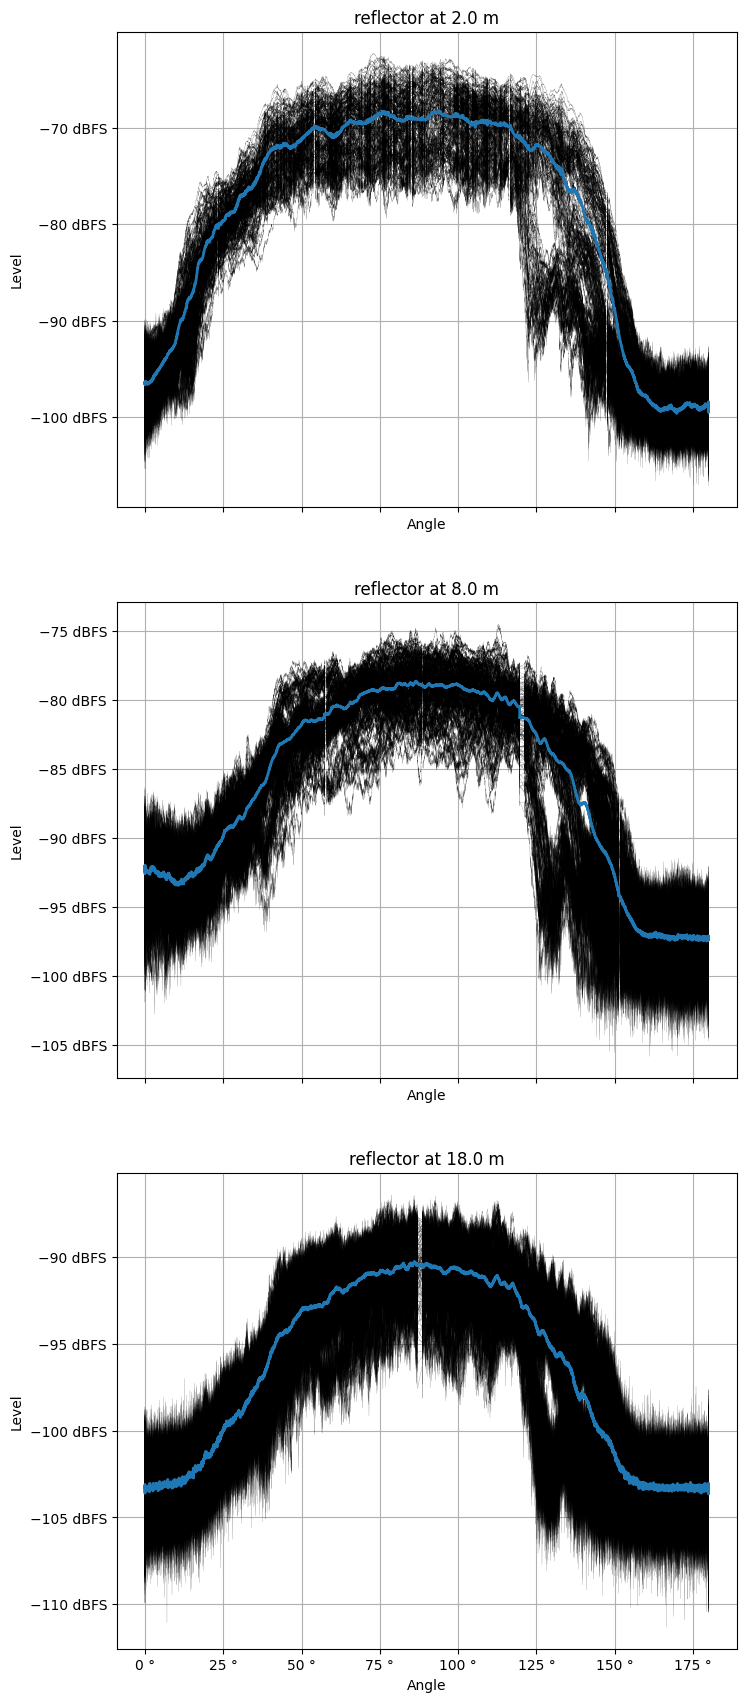

In [6]:
fig, ax = plt.subplots(3, sharex=True)
fig.set_size_inches((8,21))
for n, dist in enumerate((2,8,18)):
    data = torch.load(f'{folder}a{dist:02d}_data.pt')*2**8/2**11
    M,K,L = data.shape
    with open(f'{folder}a{dist:02d}_timestamps.pkl', 'rb') as f:
        timestamps = pickle.load(f)
    with open(f'{folder}a{dist:02d}_angle.pkl', 'rb') as f:
        angle = pickle.load(f)

    print(f'loaded data for {dist}m. processing...')
    # calculate mean 
    window = torch.hann_window(M).unsqueeze(-1)
    window = window / window.sum()

    bp = torch.zeros(nfft)
    bp_start = int((dist-0.5)*bins_per_meter)
    bp_len = int(1*bins_per_meter)
    bp[bp_start:bp_start+bp_len] = torch.ones(bp_len)
    bp = bp.unsqueeze(-1)

    data_abs_mean = torch.zeros(L)
    angle_deg =[180/pi*a for a in angle]
    for k in range(K-1,-1,-1):
        fft = torch.fft.fft(window*data[:,k,:], n=nfft, dim=0)
        channel_mean = torch.mean(fft.abs()*bp, dim=0)
        # ax[n].plot(angle_deg, 20*channel_mean.log10(), color='k' if k else 'r', linewidth=0.1 if k else 1)
        ax[n].plot(angle_deg, 20*channel_mean.log10(), color='k', linewidth=0.1)
        data_abs_mean += channel_mean/K

    ax[n].plot(angle_deg, 20*data_abs_mean.log10(), linewidth=2)
    # plot data
    ax[n].yaxis.set_major_formatter(EngFormatter(unit='dBFS'))
    ax[n].xaxis.set_major_formatter(EngFormatter(unit='°'))
    ax[n].set_title(f'reflector at {dist}.0 m')
    ax[n].set_xlabel('Angle')
    ax[n].set_ylabel('Level')
    ax[n].grid()

A subset of characteristics drops to 0dB between 110-150°. Let's find out which ones they are.

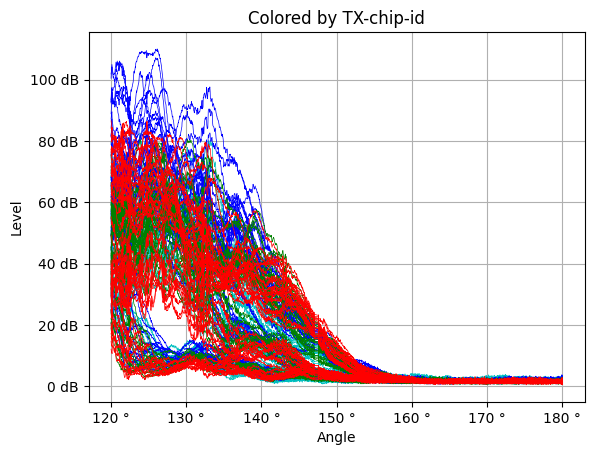

In [7]:
dist = 2
data = torch.load(f'{folder}a{dist:02d}_data.pt')
M,K,L = data.shape
with open(f'{folder}a{dist:02d}_timestamps.pkl', 'rb') as f:
    timestamps = pickle.load(f)
with open(f'{folder}a{dist:02d}_angle.pkl', 'rb') as f:
    angle = pickle.load(f)

l_sel = [l for l,a in enumerate(angle) if 120<180/pi*a]
# calculate mean 
window = torch.hann_window(M).unsqueeze(-1)
window = window / window.sum() * 2**15
bp = torch.zeros(nfft)
bp_start = int((dist-0.5)*bins_per_meter)
bp_len = int(1*bins_per_meter)
bp[bp_start:bp_start+bp_len] = torch.hann_window(bp_len)
bp = bp.unsqueeze(-1)

data_abs_mean = torch.zeros(len(l_sel))
angle_deg =[180/pi*a for a in angle if 120<180/pi*a]
for k in range(K):
    fft = torch.fft.fft(window*data[:,k,l_sel], n=nfft, dim=0)
    channel_mean = torch.mean(fft.abs()*bp, dim=0)
    plt.plot(angle_deg, channel_mean, color='cbgr'[k//48], linewidth=0.5)
    data_abs_mean += channel_mean/K

plt.gca().yaxis.set_major_formatter(EngFormatter(unit='dB'))
plt.gca().xaxis.set_major_formatter(EngFormatter(unit='°'))
plt.title(f'Colored by TX-chip-id')
plt.xlabel('Angle')
plt.ylabel('Level')
plt.grid()

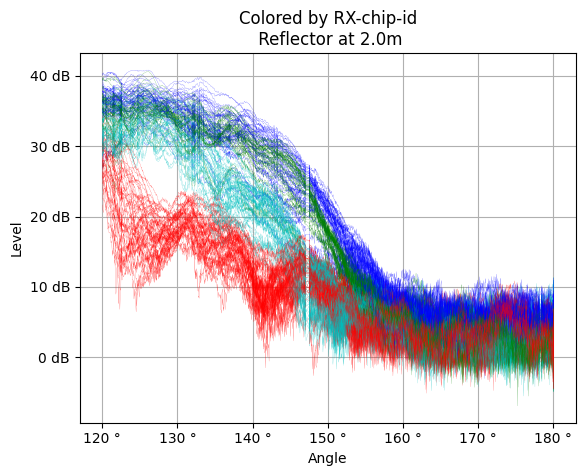

In [8]:
dist = 2
data = torch.load(f'{folder}a{dist:02d}_data.pt')
M,K,L = data.shape
with open(f'{folder}a{dist:02d}_timestamps.pkl', 'rb') as f:
    timestamps = pickle.load(f)
with open(f'{folder}a{dist:02d}_angle.pkl', 'rb') as f:
    angle = pickle.load(f)

l_sel = [l for l,a in enumerate(angle) if 120<180/pi*a]
# calculate mean 
window = torch.hann_window(M).unsqueeze(-1)
window = window / window.sum() * 2**15
bp = torch.zeros(nfft)
bp_start = int((dist-0.5)*bins_per_meter)
bp_len = int(1*bins_per_meter)
bp[bp_start:bp_start+bp_len] = torch.hann_window(bp_len)
bp = bp.unsqueeze(-1)

angle_deg =[180/pi*a for a in angle if 120<180/pi*a]
for k in range(K):
    fft = torch.fft.fft(window*data[:,k,l_sel], n=nfft, dim=0)
    channel_mean = torch.mean(fft.abs()*bp, dim=0)
    plt.plot(angle_deg, 20*channel_mean.log10(), color='cbgr'[(k%16)//4], linewidth=0.1, label='' if k%48 else f'chip {(k%16)//4}')

plt.gca().yaxis.set_major_formatter(EngFormatter(unit='dB'))
plt.gca().xaxis.set_major_formatter(EngFormatter(unit='°'))
plt.title(f'Colored by RX-chip-id\n Reflector at 2.0m')
plt.xlabel('Angle')
plt.ylabel('Level')
plt.grid()

Betroffen sind die TX-Antennen auf der linken Seite des Arrays. Diese werden von der Halterung der Dreheinheit abgeschattet